<a href="https://colab.research.google.com/github/cristianbalea/ml-project/blob/main/proiect_balea_ciobanica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock, Paper, Scissors image classification

## Downloading the dataset from Kaggle

In [1]:
! pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d drgfreeman/rockpaperscissors

! unzip rockpaperscissors.zip

Saving kaggle.json to kaggle.json
 97% 298M/306M [00:03<00:00, 114MB/s] 
100% 306M/306M [00:03<00:00, 102MB/s]
Archive:  rockpaperscissors.zip
  inflating: README_rpc-cv-images.txt  
  inflating: paper/04l5I8TqdzF9WDMJ.png  
  inflating: paper/0Og76sl5CJhbxWWx.png  
  inflating: paper/0RA9rcrv8iVvuDDU.png  
  inflating: paper/0Uomd0HvOB33m47I.png  
  inflating: paper/0a3UtNzl5Ll3sq8K.png  
  inflating: paper/0cb6cVL8pkfi4wF6.png  
  inflating: paper/0eqArS2GgsBeqgSn.png  
  inflating: paper/0t08v9bAaA0mXGCQ.png  
  inflating: paper/0vugygEjxQJPr9yz.png  
  inflating: paper/0zKU6wEhT2cDe9j0.png  
  inflating: paper/14K62H4KG1hg5qiJ.png  
  inflating: paper/1Dfw5FRlS4h60JPX.png  
  inflating: paper/1Frbe8cdOdkciOBg.png  
  inflating: paper/1Tt9U9SzrOm98Xtw.png  
  inflating: paper/1fKclJk4eBWOQSR1.png  
  inflating: paper/1jHtb93pI8f6pfKo.png  
  inflating: paper/1oKnUgV2CdCaQUUX.png  
  inflating: paper/1uoW7QcH2qAgCTxv.png  
  inflating: paper/1yKjzquSvl9ShK7K.png  
  inflating: paper/

## Importing the libraries

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import os 

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from keras.optimizers import RMSprop
from keras.preprocessing import image

## Organize the **dataset**

In [3]:
build_dir = '/content/rps-cv-images'

rock_dir = os.path.join(build_dir, 'rock')
paper_dir = os.path.join(build_dir, 'paper')
scissors_dir = os.path.join(build_dir, 'scissors')

os.listdir(build_dir)

['scissors', 'paper', 'README_rpc-cv-images.txt', 'rock']

In [4]:
print('paper: ', len(os.listdir(paper_dir)))
print('scissors: ', len(os.listdir(scissors_dir)))
print('rock: ', len(os.listdir(rock_dir)))

paper:  712
scissors:  750
rock:  726


## Data preprocessing

### Data Augmentation

In [5]:
generator = ImageDataGenerator(validation_split=0.2, 
                               rescale=1/255, 
                               shear_range=0.2, 
                               zoom_range=0.2, 
                               rotation_range=20, 
                               fill_mode='nearest')
train_data = generator.flow_from_directory(build_dir, 
                                           batch_size=32, 
                                           target_size=(150,150), 
                                           subset='training')
val_data = generator.flow_from_directory(build_dir, 
                                         batch_size=32,
                                         target_size=(150,150),
                                         subset='validation')

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


# Create a model

In [6]:
# Create a sequential model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 output classes: rock, paper, scissors

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model

In [7]:
class Callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.90):
            print("\nReached %2.2f%% accuracy, training has been stop" %(logs.get('accuracy')*100))
            self.model.stop_training = True
callbacks = Callbacks()


In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [9]:
historyModel = model.fit(
    train_data,
    steps_per_epoch = 25,
    epochs = 20,
    validation_data = val_data,
    validation_steps = 5,
    verbose = 2,
    callbacks = [callbacks])

Epoch 1/20
25/25 - 51s - loss: 1.1526 - accuracy: 0.3487 - val_loss: 1.0967 - val_accuracy: 0.3875 - 51s/epoch - 2s/step
Epoch 2/20
25/25 - 33s - loss: 0.9604 - accuracy: 0.5425 - val_loss: 0.7705 - val_accuracy: 0.6875 - 33s/epoch - 1s/step
Epoch 3/20
25/25 - 33s - loss: 0.7522 - accuracy: 0.6953 - val_loss: 0.6307 - val_accuracy: 0.7750 - 33s/epoch - 1s/step
Epoch 4/20
25/25 - 33s - loss: 0.5961 - accuracy: 0.7775 - val_loss: 0.4048 - val_accuracy: 0.8625 - 33s/epoch - 1s/step
Epoch 5/20
25/25 - 33s - loss: 0.3497 - accuracy: 0.8813 - val_loss: 0.3713 - val_accuracy: 0.8750 - 33s/epoch - 1s/step
Epoch 6/20

Reached 91.87% accuracy, training has been stop
25/25 - 33s - loss: 0.2294 - accuracy: 0.9187 - val_loss: 0.1829 - val_accuracy: 0.9375 - 33s/epoch - 1s/step


1/1 [==============================] - 0s 105ms/step
Paper


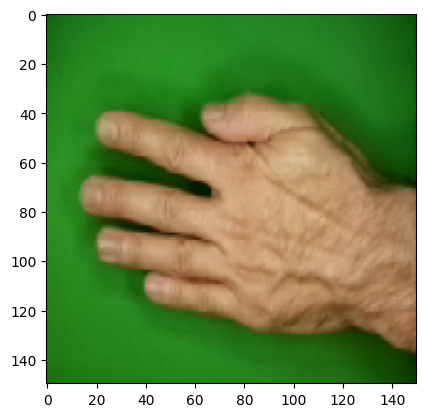

In [10]:
uploaded = os.path.join(paper_dir,'0Og76sl5CJhbxWWx.png')
img = tf.keras.utils.load_img(uploaded, target_size = (150, 150))
 
imgplot = plt.imshow(img)
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=10)  
if classes[0][0] == 1:
  print('Paper')
elif classes[0][1] == 1:
  print('Rock')
else:
  print('Scissors')

# Evaluation

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_data, steps=val_data.n)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

 14/437 [..............................] - ETA: 2:58 - loss: 0.2105 - accuracy: 0.9314

437/437 [==============================] - 6s 13ms/step - loss: 0.2105 - accuracy: 0.9314
Test Loss: 0.21049420535564423
Test Accuracy: 0.9313501119613647


# Rock, Paper, Scissor Game

In [12]:
def game(hand_1, hand_2):
  img1 = tf.keras.utils.load_img(hand_1, target_size = (150, 150))
  
  #imgplot1 = plt.imshow(img1)
  x1 = tf.keras.utils.img_to_array(img1)
  x1 = np.expand_dims(x1, axis=0)
  images1 = np.vstack([x1])

  classes1 = model.predict(images1, batch_size=10)  

  img2 = tf.keras.utils.load_img(hand_2, target_size = (150, 150))
  
  #imgplot2 = plt.imshow(img2)
  x2 = tf.keras.utils.img_to_array(img2)
  x2 = np.expand_dims(x2, axis=0)
  images2 = np.vstack([x2])

  classes2 = model.predict(images2, batch_size=10)  

  plt.subplot(1, 2, 1)  # Create a subplot for img1
  plt.imshow(img1)
  plt.title('Image 1')
  plt.xlabel(f'Class: {np.argmax(classes1)}')

  plt.subplot(1, 2, 2)  # Create a subplot for img2
  plt.imshow(img2)
  plt.title('Image 2')
  plt.xlabel(f'Class: {np.argmax(classes2)}')

  plt.tight_layout()  # Adjust spacing between subplots
  plt.show()

  if classes1[0][0] == 1:
    h1 = 'paper'
  elif classes1[0][1] == 1:
    h1 = 'rock'
  else:
    h1 = 'scissors'


  if classes2[0][0] == 1:
    h2 = 'paper'
  elif classes2[0][1] == 1:
    h2 = 'rock'
  else:
    h2 = 'scissors'


  print("h1: ", h1)
  print("h2: ", h2)


  if h1 == 'paper':
    if h2 == 'rock':
      print("hand 1 won")
    elif h2 == 'paper':
      print("draw")
    else:
      print("hand 2 won")

  if h1 == 'rock':
    if h2 == 'paper':
      print("hand 2 won")
    elif h2 == 'rock':
      print("draw")
    else:
      print("hand 1 won")

  if h1 == 'scissors':
    if h2 == 'rock':
      print("hand 2 won")
    elif h2 == 'scissors':
      print("draw")
    else:
      print("hand 1 won")

1/1 [==============================] - 0s 30ms/step


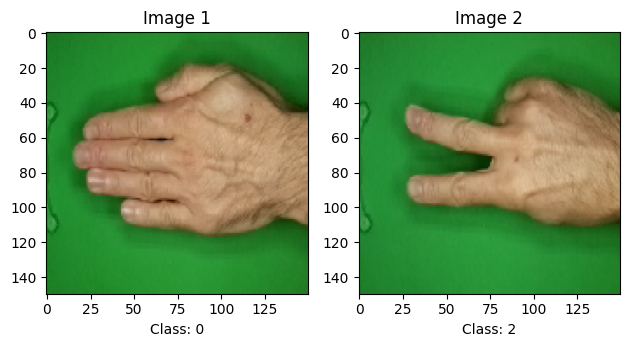

h1:  paper
h2:  scissors
hand 2 won


In [13]:
hand_1 = '/content/rps-cv-images/paper/0a3UtNzl5Ll3sq8K.png'
hand_2 = '/content/rps-cv-images/scissors/2M8LvUBGMOH1bsaz.png'

game(hand_1, hand_2)